# 2018-05-09 - CHAMP output binaire
Pour valider la robustesse de l'apprentissage du layer 1 :

On importe les MC et on les filtre :

Size= torch.Size([1, 400, 1, 64, 64])
Gaussian filtered


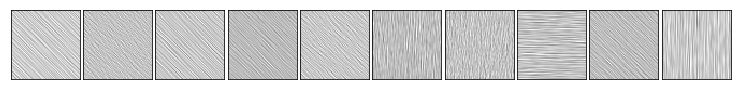

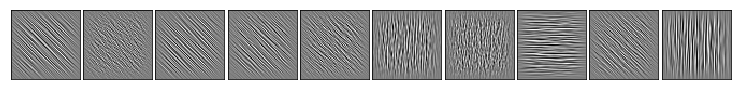

In [1]:
%matplotlib inline
import CHAMP.MC as MotionClouds
from CHAMP.DataLoader import LoadData, LoadCloudsDB
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData
from CHAMP.Monitor import DisplayDico
import os

path = './clouds_easy'

TrSet, TeSet = LoadData(name = 'Clouds', data_path =path, decorrelate=False, resize=None, download = False,
                       clouds_diff = 'easy')
to_display = TrSet[0][0, 0:10, :, :, :] #displays 10 clouds

print('Size=', TrSet[0].shape)
DisplayDico(to_display)

Normalized_TrSet, _, _, _ = LocalContrastNormalization(TrSet)
to_display = Normalized_TrSet[0][0, 0:10, :, :, :]

Filtered_L_TrSet = FilterInputData(
    Normalized_TrSet, sigma=0.25, style='Custom', start_R=15)
to_display = Filtered_L_TrSet[0][0, 0:10, :, :, :]
print("Gaussian filtered")
DisplayDico(to_display)

Premier layer convo : On entraine le réseau (4 mn/200 epochs sur une 1080) :

In [3]:
from CHAMP.CHAMP_Layer import CHAMP_Layer
from CHAMP.DataLoader import LoadData
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData, GenerateMask
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayWhere

# MP Parameters
nb_dico = 12
width = 10
dico_size = (width, width)
l0 = 20
seed = 30
# Learning Parameters
eta = .05
nb_epoch = 200

#expect approx 10mn of training for 500 epochs
#or 10 minutes on 100 epochs if running on CPU
L1 = CHAMP_Layer(l0_sparseness=l0, nb_dico=nb_dico,
                 dico_size=dico_size, verbose=2)
dico = L1.TrainLayer(Filtered_L_TrSet, eta=eta, nb_epoch=nb_epoch, seed=seed)

import pickle 
pickle.dump(L1, open('L1.p', 'wb'))

NameError: name 'Filtered_L_TrSet' is not defined

In [2]:
import pickle
from CHAMP.CHAMP_Layer import CHAMP_Layer
from CHAMP.DataLoader import LoadData
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData, GenerateMask
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayWhere

L1 = pickle.load( open('L1.p', 'rb'))

On display :

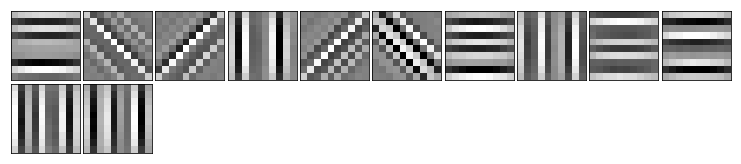

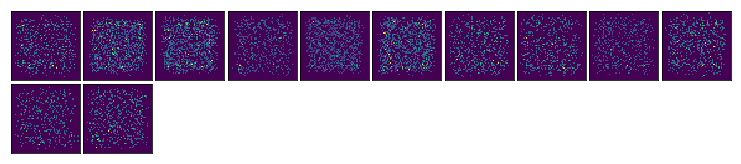

In [3]:
DisplayDico(L1.dictionary)
DisplayWhere(L1.where)

On binarise au seuil de 0.01 :

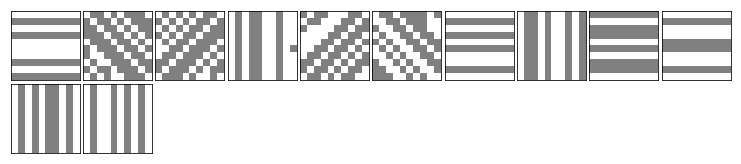

In [4]:
for a, x in enumerate(L1.dictionary) :
    for b, y in enumerate(x) : 
        for c, z in enumerate(y) :
            for d, h in enumerate(z):
                if h < 0.001 :
                    L1.dictionary[a][b][c][d] =0.0
                else :
                    L1.dictionary[a][b][c][d] = 1.0
        
DisplayDico(L1.dictionary)
DisplayDico(L1.where)

Et on entraine pour le second layer, en reg logistique :

In [19]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


class LogReg(nn.Module) :
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(10,4)
    
    def forward(self, x):
        out = self.linear(x)
        return out
    
model = LogReg()
print(model)

#CEL en SGD
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  

LogReg(
  (linear): Linear(in_features=10, out_features=4, bias=True)
)


On fit :

In [20]:
import torch
import torchvision
from torchvision import transforms, datasets

epochs = 50 
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=12, shuffle=True,
                                             num_workers=1, drop_last = True)

for epoch in range(epochs ):
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        L1dico = Variable(L1.dictionary)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(L1dico)
        outputs = outputs.view(-1,40)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, epochs, i+1, len(train_set)//12, loss.data[0]))

AttributeError: 'LogReg' object has no attribute 'leaky_relu'

On teste :

In [13]:
test_loss = 0
correct = 0

test_set = datasets.ImageFolder(root='clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=12,shuffle=False,
                                             num_workers=1,drop_last = True)

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 32 * 32)
    net_out = model(L1dico)
    net_out = net_out.view(-1,40)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.2868, Accuracy: 20/100 (20%)

